In [1]:
### import necessary libraries
import ee
import geemap
import sklearn
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
ee.Authenticate()
ee.Initialize(project="omdena-italy")

In [3]:
# Import the dataset
chirps = ee.ImageCollection("UCSB-CHG/CHIRPS/PENTAD")

year = 2019

startDate = ee.Date.fromYMD(year, 1, 1)
endDate = startDate.advance(1, 'year')

year_filtered = chirps.filter(ee.Filter.date(startDate, endDate))
print(year_filtered.size().getInfo())
print(year_filtered.getInfo())

months = ee.List.sequence(1, 12)

def create_monthly_image(month):
    startDate = ee.Date.fromYMD(year, month, 1)
    endDate = startDate.advance(1, 'month')
    month_filtered = year_filtered.filter(ee.Filter.date(startDate, endDate))
    monthly_total = month_filtered.sum()
    return monthly_total.set({
        'system:time_start':startDate.millis(),
        'month': month, 
        'year': year})


monthly_images = months.map(create_monthly_image)
print(monthly_images.size().getInfo())
print(monthly_images.getInfo())

monthly_collection = ee.ImageCollection.fromImages(monthly_images)
print(monthly_collection.size().getInfo())

72
{'type': 'ImageCollection', 'bands': [], 'id': 'UCSB-CHG/CHIRPS/PENTAD', 'version': 1705106289782760.0, 'properties': {'system:visualization_0_min': '0.0', 'type_name': 'ImageCollection', 'keywords': ['chg', 'climate', 'geophysical', 'precipitation', 'ucsb', 'weather'], 'thumb': 'https://mw1.google.com/ges/dd/images/CHIRPS_thumb.png', 'description': '<p>Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS)\nis a 30+ year quasi-global rainfall dataset. CHIRPS incorporates\n0.05° resolution satellite imagery with in-situ station data\nto create gridded rainfall time series for trend analysis and seasonal\ndrought monitoring.</p><p><b>Provider: <a href="https://chc.ucsb.edu/data/chirps">UCSB/CHG</a></b><br><p><b>Resolution</b><br>5566 meters\n</p><p><b>Cadence</b><br>\n    1\n  pentad\n<br>Each asset spans a pentad. Each of first 5 pentads in a month\nhave 5 days. The last pentad contains all the days from the 26th to the\nend of the month.\n</p><p><b>Bands</b><table 

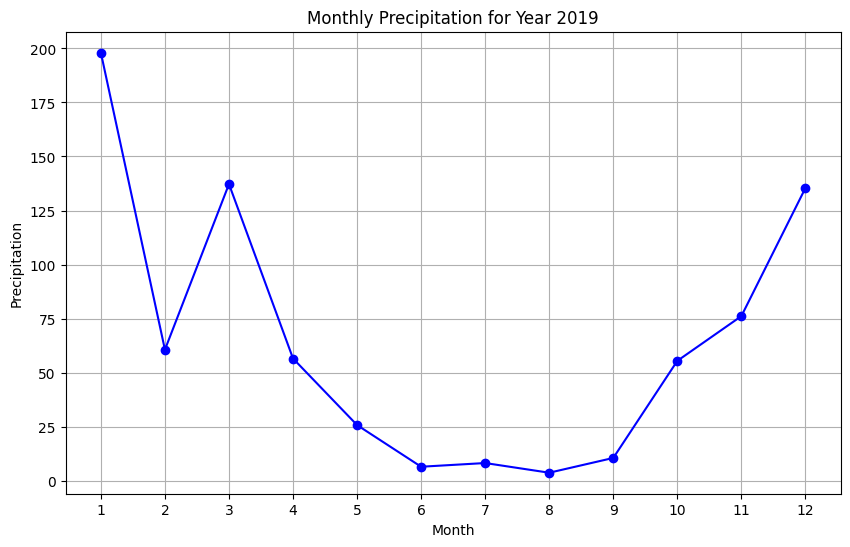

In [7]:
# Define your geometry for the region of interest
geometry = ee.Geometry.Polygon(
    [[[-64.66951462701107, -30.988041266566547],
      [-64.66951462701107, -31.67053357441487],
      [-63.68100898649021, -31.67053357441487],
      [-63.68100898649021, -30.988041266566547],
      [-64.66951462701107, -30.988041266566547]]])

def create_monthly_stats(month: ee.Number) -> ee.Feature:
    start_date = ee.Date.fromYMD(year, month, 1)
    end_date = start_date.advance(1, 'month')
    month_filtered = year_filtered.filter(ee.Filter.date(start_date, end_date))
    monthly_total = month_filtered.sum()
    mean_precip = monthly_total.reduceRegion(
        reducer=ee.Reducer.mean(), 
        geometry=geometry, 
        scale=5566
    )
    return ee.Feature(None, mean_precip)

# Apply the function to each month and create a FeatureCollection
monthly_stats = ee.FeatureCollection(months.map(create_monthly_stats))

# Now fetch the results
monthly_data = monthly_stats.getInfo()['features']

# Extract precipitation values and months for plotting
precip_values = [feature['properties']['precipitation'] for feature in monthly_data]  # Adjust 'precipitation' if necessary
months = range(1, 13)

# Plotting with Matplotlib
plt.figure(figsize=(10, 6))
plt.plot(months, precip_values, marker='o', linestyle='-', color='b')
plt.title('Monthly Precipitation for Year {}'.format(year))
plt.xlabel('Month')
plt.ylabel('Precipitation')
plt.xticks(months)
plt.grid(True)
plt.show()